## GAN 개요

백쿼리 : 하나의 숫자를 표현하는 원핫 인코딩 벡터를 이미 훈련된 네트워크에 넣어서 숫자에 맞는 이상적인 이미지를 거꾸로 만들어냄 

* 같은 벡터는 같은 결과를 출력
* 그 레이블을 나타내는 모든 훈련 데이터의 뭔가 평균적인 이미지가 나옴

적대적 훈련
* 분류기의 출력이 0과 1

훈련을 거듭할수록 잘 판별함

가짜이미지를 만드는 생성자(generator)생성
분류기(discriminator)

손실함수 : 판별기를 무사히 속이면 보상
판별기에 잡히면 벌을 줌

생성기의 성능이 좋지 않다면 생성기만 훈련시키면 점점 좋은 fake를 생성할 것 

판별기가 훈련을 거치며 점점 성능이 좋아질수록, 생성기 또한 보상과 벌을 통해 훈련이 되어 성능이 증가 할 것

서로 적대적 관계로 경쟁을 하게됨 : Generative adversarial network ,GAN


GAN 훈련 
* 하지 말아야 할 미련한 방법 : 둘중 하나만 먼저 훈련하고 같은 데이터로 다시 한번 다른 모델을 훈련하는 것.
* 제대로 훈련하기 위해서는 둘 모두를 동시에 훈련시키면서 양쪽 모두 비슷한 수준으로 훈련이 이루어지도록 유도해야함

이를 위해 다음과 같이 3단계로 시도
1. 판별기에 실제 데이터를 보여주고 1.0이라는 값이라고 알려줌 : 오차발생시 판별기를 업데이트하는데 사용
2. 판별기에 생성기로 부터 만들어진 가짜 데이터를 보여주고 0.0이라고 알려줌 : 오차를 통해 판별기만을 업데이트, 생성기를 업데이트하지 않음
3. 판별기에 생성기의 결과를 보여주고, 생성기에 결과가 1.0이어야 한다고 알려줌 : 생성기를 훈련, 만든 이미지를 판별기가 1로 판단하는것이 목적.생성기만을 업데이트 

실전에서는 GAN을 훈련하는 게 굉장히 까다로울 수 있음.
생성기와 판별기가 서로 적대적인 관계로 발전하게 했을 때, 두개의 성능이 서로 균형이 잘 맞춰져 있어야 GAN이 제대로 훈련됨
판별기의 성능이 너무빨리 좋아져버리거나 너무 늦게 훈련되면 부작용이 일어남


In [1]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt

In [2]:
# 실제 데이터 : 1010 패턴을 가짐 
def generate_real():
    real_data = torch.FloatTensor([1,0,1,0])
    return real_data

In [3]:
import random
# 좀더 실제상황에 가깝게 1010에 가깝게 생성
def generate_real_2() :
    real_data = torch.FloatTensor([random.uniform(0.8,1.0),
                                   random.uniform(0.0,0.2),
                                   random.uniform(0.8,1.0),
                                   random.uniform(0.0,0.2)])
    return real_data

In [4]:
generate_real_2()

tensor([0.8128, 0.1837, 0.9291, 0.1083])

## 판별기(Discriminator)
* 1010패턴 데이터는 진짜이므로 목표 출력 1.0
* 임의의 노이즈 데이터는 가짜이므로 목표 출력 0.0


In [10]:
# discriminator

class Discriminator(nn.Module) :
    def __init__(self) :
        super().__init__()
    
        # layer
        self.model = nn.Sequential(
            nn.Linear(4,3),     # input =  4
            nn.Sigmoid(),
            nn.Linear(3,1),     # output = 1
            nn.Sigmoid() 
        )
        # loss
        self.loss_function = nn.MSELoss()
        
        # optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # initialization
        self.counter = 0;
        self.progress = []
        
        pass
    
    def forward(self, inputs) :
        # model start
        return self.model(inputs)
    
    def train(self, inputs, targets) :
        outputs = self.forward(inputs)
        
        #loss
        loss = self.loss_function(outputs, targets)
        
        # counter record 10 epoch
        self.counter +=1 
        if (self.counter % 10 == 0) :
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0) :
            print("counter =", self.counter)
            pass
        
        # update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

In [11]:
def generate_random(size) :
    random_data = torch.rand(size)
    return random_data 

In [12]:
generate_random(4)

tensor([0.8195, 0.2364, 0.4239, 0.6986])

In [13]:
# 1010 패턴 데이터는 진짜 = 1.0 
# 노이즈 데이터는 가짜, 목표 출력 = 0.0

D = Discriminator()

for i in range(10000) :
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # generated data 
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass


counter = 10000
counter = 20000


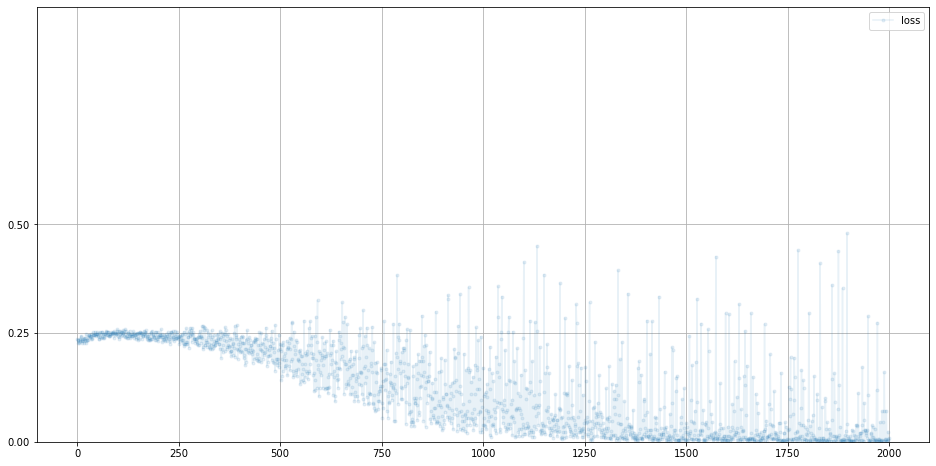

In [14]:
# discriminator loss
# 0.25에서 시작, 1010패턴에 적응하면서 점점 성능이 나아짐..0을 향해서 나아감 

D.plot_progress()

In [15]:
# check discriminator
print(D.forward(generate_real()).item()) # 1010 : 1에 가까운 값
print(D.forward(generate_random(4)).item()) # random : fake 0에 가까운 값 

0.8464428782463074
0.04495527967810631


## 생성기(Generator)
* 판별기의 반대, node 1 -> node 4 로 생성
* 은닉 layer의 경우 정해진 것 없이 설정 가능
* input layer node 1, hidden layer node 3, output layer node 4 

In [16]:
# Generator class

class Generator(nn.Module) :
    def __init__(self) :
        super().__init__()
    
        # layer
        self.model = nn.Sequential(
            nn.Linear(1,3),     # input =  1
            nn.Sigmoid(),
            nn.Linear(3,4),     # output = 4
            nn.Sigmoid() 
        )
        # loss는 필요 없음 : 손실 함수는 오직 판별기의 결과에만 적용이 됨, 생성기는 판별기로 부터 흘러온 기울기 오차를 통해 업데이트
        
        # optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # initialization
        self.counter = 0;
        self.progress = []
        
        pass
    
    def forward(self, inputs) :
        # model start
        return self.model(inputs)
    
    
    # 생성기를 훈련 시킬때는 판별기가 필요. 
    # D : Discriminator
    def train(self, D, inputs, targets) :
        g_outputs = self.forward(inputs)
        
        # 판별기로 전달
        d_output = D.forward(g_outputs)
        
        # loss 계산 : D만 하면 됨
        loss = D.loss_function(d_output, targets)
        
        # counter record 10 epoch
        self.counter +=1 
        if (self.counter % 10 == 0) : 
            self.progress.append(loss.item())
            pass
        
        # update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

In [17]:
# G의 출력은 4개를 가짐 
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5765, 0.4823, 0.7250, 0.6549], grad_fn=<SigmoidBackward>)

## Training GAN

In [18]:
%%time

# 판별기 및 생성기 생성
D = Discriminator()
G = Generator()

for i in range(10000) :
    
    # 1단계 : 참에 대해 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # 2단계 : 거짓에 대해 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용 : backward에서 G까지 계산되지 않도록 함 
    # 이렇게 하는 이유 : 큰 네트워크에서 불필요한 계산을 하지 않기 위해서 
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # 3단계 : G 훈련 
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    pass

counter = 10000
counter = 20000
CPU times: user 11.7 s, sys: 26.2 ms, total: 11.8 s
Wall time: 11.8 s


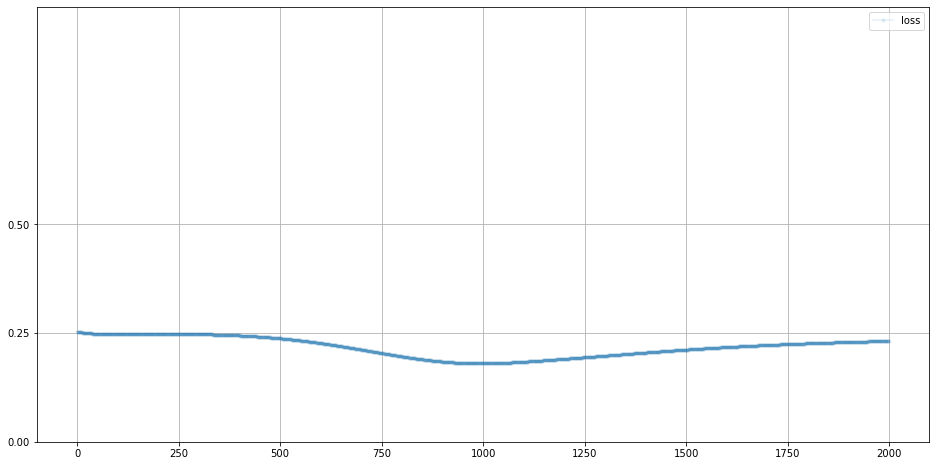

In [19]:
D.plot_progress()

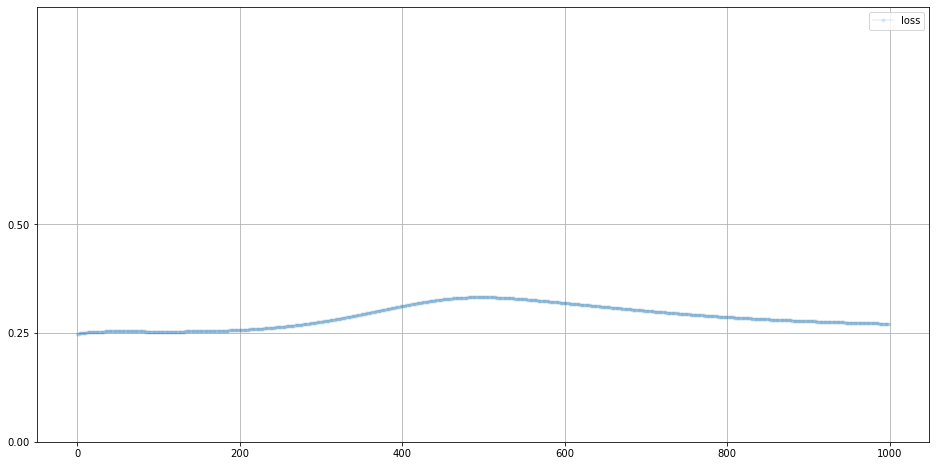

In [20]:
G.plot_progress()

In [21]:
# check the output
# 1010패턴에 매우 가깝게 생성함 
G.forward(torch.FloatTensor([0.5]))

tensor([0.9401, 0.0206, 0.9545, 0.0213], grad_fn=<SigmoidBackward>)